# Problem set 8: Mini-project

We've put some effort into building our collection (see problem set 7 for details and for links to texts and to metadata). Now it's time to learn something about it. You already have lots of excellent ideas for how to apply the tools we've learned about so far. It's also a good time of the semester to review what we have learned and practice applying it in less structured settings.

**You will work by yourself or in a group of up to three people** to complete a short project applying methods from the previous weeks to this collection. You will turn in the completed project as a single notebook (one submission per group) with the following sections:

1. **Question(s).** Describe what you wanted to learn. Suggest several possible answers or hypotheses, and describe in general terms what you might expect to see if each of these answers were true (save specific measurements for the next section). For example, many students want to know the difference between horror and non-horror, or between detective stories and horror fiction, but there are many ways to operationalize this question. You do not need to limit yourself to questions of genre. **Note that your question should be interesting! If the answer is obvious before you begin, or if it's something the importance of which you cannot explain, your grade will suffer (a lot).** (10 points)

1. **Methods.** Describe how you will use computational methods presented so far in this class to answer your question. What do the computational tools do, and how does their output relate to your question? Describe how you will process the collection into a form suitable for a model or algorithm and why you have processed it the way you have. (10 points)

1. **Code.** Carry out your experiments. Code should be correct (no errors) and focused (unneeded code from examples is removed). Use the notebook format effectively: code may be incorporated into multiple sections. (20 points)

1. **Results and discussion.** Use sorted lists, tables, and visual presentations to make your argument. Excellent projects will provide multiple views of results, and follow up on any apparent outliers or strange cases, including through careful reading of the original documents. (40 points)

1. **Reflection.** Describe your experience in this process. What was harder or easier than you expected? What compromises or negotiations did you have to accept to match the collection, the question, and the methods? What would you try next? (10 points)

1. **Responsibility and resources consulted.** Credit any online sources (Stack Overflow, blog posts, documentation) that you found helpful. (0 points, but -10 if missing)
    * **If you worked in a group**, set up a group submission in CMS. Each group member should submit (via CMS) a separate text file in which they describe each member's (including their own) contributions to the project.
    * Most people will turn in *either* a completed notebook for their solo project *or* a responsibility statement. The only people who will submit both files are those who are the designated submitter for their group. Don't worry if CMS warns you about a missing file (unless you're the group submitter).

Note that 10 points will be carried over from problem set 7.

**We will grade this work based on accuracy, thoroughness, creativity, reflectiveness, and quality of presentation.**

**Scope:** this is a *mini*-project, with a short deadline. We are expecting work that is consistent with that timeframe, but that is serious, thoughtful, and rigorous. This problem set will almost certainly require more time and effort than many of the others. **For group work, the expected scope grows linearly with the number of participants.**

# 0. Project team

Joshua Hong (jh976)

# 1. Question(s)

What are important features in determining gender or adaptation and how accurately can we classify them? 

# 2. Methods

I want to use the classification methods as seen in class to see accuracy for determining adapatation or gender. So, in order to fit the models and classifiers, I found the unique values of each column (I thought would be important for using as a feature) and gave them numerical values based on the index. Then I used 4 classifiers in order to see the accuracy of each model in prediciting the target (either adaptation and gender). 

# 3. Code

In [1]:
# Imports (all of them!)
%matplotlib inline
import numpy as np
import os
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from glob import glob
from sklearn.decomposition import TruncatedSVD
import string
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from collections import defaultdict
from sklearn.inspection import permutation_importance
from sklearn.ensemble import ExtraTreesClassifier

In [92]:
corpus_csv = os.path.join('..', '..', 'data', 'corpus_list.csv')
corpus_csv = pd.read_csv(corpus_csv)
c_csv = corpus_csv.copy() #copying df 
novel_files = glob(os.path.join('..', '..', 'data','corpus_file', '*.txt'))
emolex_file = os.path.join('..', '..','data','lexicons','emolex.txt')

In [93]:
def compare_scores(scores_dict): # code from class 
    '''
    Takes a dictionary of cross_validate scores.
    Returns a color-coded Pandas dataframe that summarizes those scores.
    '''
    import pandas as pd
    df = pd.DataFrame(scores_dict).T.applymap(np.mean).style.background_gradient(cmap='RdYlGn')
    return df

In [94]:
def tokenize_text(text, stopwords=None):
    '''
    Takes a string.
    Returns a list of tokenized sentences.
    '''
    tokenized_text = []
    for sent in sent_tokenize(text):
        tokens = word_tokenize(sent.lower())
        if stopwords != None:
            tokens = [token for token in tokens if token not in stopwords]
        tokenized_text.append(tokens)
    return tokenized_text

# Build stopword list with punctuation
stopwords = set(['and','but','am','is','are','was','were','be','being','been','the','a','an','of',
                'on','under','above','out','in','at','with','have','has','had', "'s"])
stopwords = stopwords.union(set(string.punctuation))

In [95]:
# read and parse the emolex file
def read_emolex(filepath=None):
    '''
    Takes a file path to the emolex lexicon file.
    Returns a dictionary of emolex sentiment values.
    '''
    if filepath==None: # Try to find the emolex file
        filepath = emolex_file
        if os.path.isfile(filepath):
            pass
        elif os.path.isfile('emolex.txt'):
            filepath = 'emolex.txt'
        else:
            raise FileNotFoundError('No EmoLex file found')
    emolex = defaultdict(dict) # Like Counter(), defaultdict eases dictionary creation
    with open(filepath, 'r') as f:
    # emolex file format is: word emotion value
        for line in f:
            word, emotion, value = line.strip().split()
            emolex[word][emotion] = int(value)
    return emolex

# Get EmoLex data
emolex = read_emolex(emolex_file)

In [96]:
# Sentiment scoring function
def sentiment_score(token_list, lex=None):
    '''
    Takes a tokenized sentence.
    Returns a dictionary of length-normalized EmoLex sentiment scores.
    '''
    if lex==None: # reading emolex everytime
        lex = read_emolex() 
    sent_score = { #making a dictionary with the scores and sentiments
  'anger': 0.0, 
  'anticipation': 0.0, 
  'disgust': 0.0, 
  'fear': 0.0, 
  'joy': 0.0, 
  'negative': 0.0, 
  'positive': 0.0, 
  'sadness': 0.0, 
  'surprise': 0.0, 
  'trust': 0.0
    }
    count = 0 
    for i, sent in enumerate(token_list): #so since we are not actually iterating through token list, we have to seperate each tokenized text into token list and index
        for x in sent: #so after seperating, we look at each token list 
            if x in emolex: # if an element in the list is in emolex 
                for y in sent_score: # we then iterate through our own dictionary we have (above)
                    sent_score[y] = sent_score[y] + emolex[x][y] #and we look at every element in our sent_score dict and update the scores based on the numbers in emolex[word][sentiment]
            count += 1 #this counts each sentence (can change, up to you, can indent again for every element)
    for i in sent_score: #you can comment this out to see the actual scores of each emotion (as in how many times each emotion is present)
        sent_score[i] = sent_score[i]/count #each score/count
    return(sent_score)

In [97]:
for i in range(len(c_csv)): # changing male = 1 & female = 0
    if c_csv['gender'][i] == 'female':
        c_csv['gender'][i] = 0
    elif c_csv['gender'][i] == 'male': 
        c_csv['gender'][i] = 1
    if c_csv['country'][i] == 'gb': #changing gb to uk since they are the same thing
        c_csv['country'][i] = 'uk'
# c_csv.head()

<ipython-input-97-089c1fa6b497>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_csv['gender'][i] = 0
<ipython-input-97-089c1fa6b497>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_csv['gender'][i] = 1
<ipython-input-97-089c1fa6b497>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_csv['country'][i] = 'uk'


In [98]:
countries_list = list(c_csv['country'].unique()) # finding unique values per columns I think are important
form_list = list(c_csv['form'].unique())
language_list = list(c_csv['language'].unique())
pov_list = list(c_csv['pov'].unique())
for i in range(len(c_csv)): # using index of the list of unique values to make values numeric since classification can't use strings in models
    c_csv['country'][i] = countries_list.index(c_csv['country'][i])
    c_csv['form'][i] = form_list.index(c_csv['form'][i])
    c_csv['language'][i] = language_list.index(c_csv['language'][i])
    c_csv['pov'][i] = pov_list.index(c_csv['pov'][i])

<ipython-input-98-e1284965f39a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_csv['country'][i] = countries_list.index(c_csv['country'][i])
<ipython-input-98-e1284965f39a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_csv['form'][i] = form_list.index(c_csv['form'][i])
<ipython-input-98-e1284965f39a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_csv['language'][i] = language_list.index(c_csv['language'][i])
<ipython-input

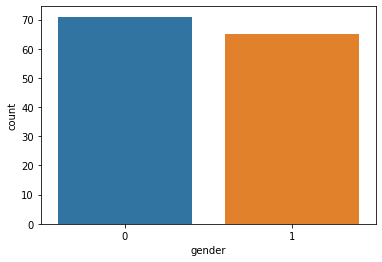

In [99]:
sns.countplot(c_csv['gender'],label="Count") 
plt.show()

In [100]:
%%time
c_csv['anger'] = 0.0 #making columns in the dataframe
c_csv['anticipation'] =0.0 
c_csv['disgust'] =0.0 
c_csv['fear'] =0.0 
c_csv['joy'] =0.0 
c_csv['negative'] =0.0 
c_csv['positive'] =0.0 
c_csv['sadness'] =0.0 
c_csv['surprise'] =0.0 
c_csv['trust'] =0.0 
corpus_scores = {} # Dictionary to hold results
for novel in novel_files: # Iterate over novels / encoding="ISO-8859-1"
    with open(novel, encoding="utf8",errors='ignore') as f: #ignoring any errors because it wouldn't matter since there are so many txts/novels
        novel_text = f.read() # Read a novel as a string
    novel_label = os.path.split(novel)[1] # Get convenience label for novel
    tokens = tokenize_text(novel_text) # Tokenize
#     for i, sent in enumerate(tokens):
    scores = sentiment_score(tokens,lex=emolex) # Score
    corpus_scores[novel_label] = scores # Record scores

CPU times: user 1min 46s, sys: 1.06 s, total: 1min 47s
Wall time: 1min 51s


In [101]:
corpus_scores

{'a_sweet_little_maid.txt': {'anger': 0.006179154560707124,
  'anticipation': 0.01929451241969145,
  'disgust': 0.004828743299095634,
  'fear': 0.00890043786062119,
  'joy': 0.017575807177640464,
  'negative': 0.01761672873102263,
  'positive': 0.03105945901706429,
  'sadness': 0.010332692228997013,
  'surprise': 0.00859352621025494,
  'trust': 0.020338012030936693},
 'Mathilda.txt': {'anger': 0.022185246810870772,
  'anticipation': 0.028629532789266568,
  'disgust': 0.016718168132477618,
  'fear': 0.02789002456223754,
  'joy': 0.028233367667643873,
  'negative': 0.04814726778121121,
  'positive': 0.05055066951905554,
  'sadness': 0.03158756569738267,
  'surprise': 0.015133507645986847,
  'trust': 0.029791617146026465},
 'the_island_of_doctor_moreau.txt': {'anger': 0.015412214034952356,
  'anticipation': 0.0148335326569191,
  'disgust': 0.009991898460707534,
  'fear': 0.023783804637166776,
  'joy': 0.012133019559430578,
  'negative': 0.04064272211720227,
  'positive': 0.028509702557771

In [102]:
sentiment_list = ['anger','anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']
for i in corpus_scores: #iterating through corpus_scores (will give novel_name.txt)
    for x in range(len(c_csv)): #iterating through c_csv df using range(len) to index each row
        if i == c_csv['filename'][x]: #if i (novel_name.txt) = c_csv['filename'][row]
            for y in sentiment_list:  #iterate through sentiment_list ->
#                 c_csv[y][x] = float(c_csv[y][x])
                c_csv[y][x] = corpus_scores[i][y] #so when c_csv[row]['sentiment'] = corpus_scores[file_name.txt]['sentiment']

<ipython-input-102-6b9be64e8954>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_csv[y][x] = corpus_scores[i][y] #so when c_csv[row]['sentiment'] = corpus_scores[file_name.txt]['sentiment']


In [103]:
c_csv.head()

,owner,check_1,check_2,filename,title,author_surname,author_givenname,year,birth_year,genre,...,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,ks2373,aj445,jw2295,Little_Women_Alcott.txt,Little Women,Alcott,Louisa May,1868,1832,"comedy, children's literature",...,0.010340,0.027066,0.008799,0.012736,0.028709,0.028802,0.051807,0.016159,0.013963,0.028673
1,jh976,sml347,jcm497,The_Great_God_Pan.txt,The Great God Pan,Arthur,Machen,1894,1863,Horror,...,0.011352,0.019807,0.010686,0.018437,0.015540,0.030689,0.034055,0.017928,0.011195,0.023682
2,jz543,asc334,aml449,The_Lost_Kafoozalum.txt,The Lost Kafoozalum,Ashwell,Pauline,1960,1928,Science Fiction,...,0.009491,0.019563,0.006082,0.015418,0.009220,0.025335,0.030100,0.012977,0.008639,0.019563
3,yw458,sml347,me363,mansfield_park.txt,Mansfield Park,Austen,Jane,1814,1775,"romance, historical",...,0.009017,0.025265,0.006784,0.012423,0.022607,0.024807,0.050260,0.012880,0.011250,0.029703
4,kjk248,ay329,jcm497,pride_and_prejudice.txt,Pride and Prejudice,Austen,Jane,1813,1775,"fiction, romance",...,0.008587,0.024625,0.006419,0.011948,0.022899,0.024843,0.051194,0.011927,0.011344,0.029052


In [171]:
M_author = [] #making lists for titles written by male or female authors 
F_author = []
for i in range(len(c_csv)): #iterating through range(len(c_csv))
    if c_csv['gender'][i] == 1: #appending all titles when gender = 1 to M_author list
        M_author.append(c_csv['title'][i])
    else:
        F_author.append(c_csv['title'][i]) #appending all titles when gender = 0 to F_author list
M_dict = defaultdict(lambda:0) #creating dictionaries to hold sentiments per author lists
F_dict = defaultdict(lambda:0)
for i in range(len(c_csv)): #
    for x in M_author:
        if x == c_csv['title'][i]: 
            for y in sentiment_list:
                M_dict[y] = M_dict[y] + c_csv[y][i]
    for a in F_author: 
        if a == c_csv['title'][i]: 
            for y in sentiment_list:
                F_dict[y] = F_dict[y] + c_csv[y][i]
for y in sentiment_list:
    M_dict[y] = M_dict[y]/len(M_author)
    F_dict[y] = F_dict[y]/len(F_author)
    
final_dict = defaultdict(lambda: defaultdict(list))
for i in sentiment_list:
    final_dict[i]['M_author'] = M_dict[i]
    final_dict[i]['F_author'] = F_dict[i]
print(len(F_author))
print(len(M_author))
display(final_dict)

71
65


defaultdict(<function __main__.<lambda>()>,
            {'anger': defaultdict(list,
                         {'M_author': 0.011110124443598808,
                          'F_author': 0.011342364337429581}),
             'anticipation': defaultdict(list,
                         {'M_author': 0.017523082295981277,
                          'F_author': 0.01975225257714346}),
             'disgust': defaultdict(list,
                         {'M_author': 0.008166411888188585,
                          'F_author': 0.008201478166205277}),
             'fear': defaultdict(list,
                         {'M_author': 0.016249191031682517,
                          'F_author': 0.015977639154352512}),
             'joy': defaultdict(list,
                         {'M_author': 0.013503438346519576,
                          'F_author': 0.01628870686263166}),
             'negative': defaultdict(list,
                         {'M_author': 0.02752832159161153,
                          'F_author': 0.

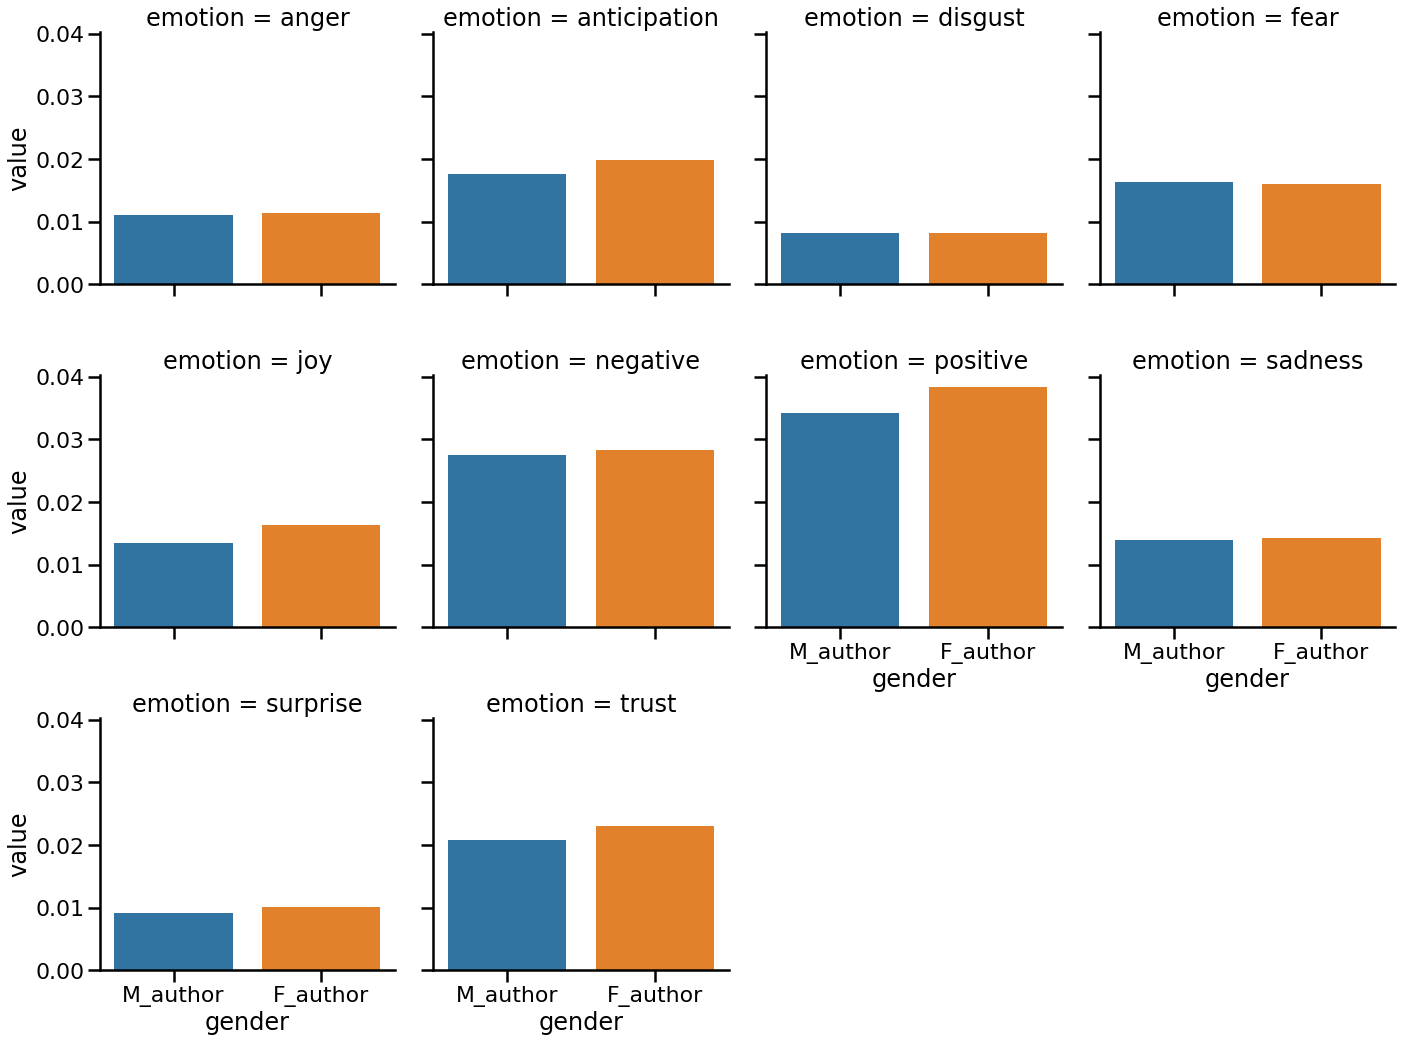

In [167]:
def visualize_emotion_scores(scores):
    import pandas as pd
    import seaborn as sns
    df = pd.DataFrame.from_dict(scores)
    values = df.columns
    df = df.reset_index().melt(id_vars='index', value_vars=values, var_name='emotion').rename(columns={'index':'gender'})
    sns.set_context('poster')
    g = sns.catplot(x='gender', y='value', col='emotion', data=df, kind='bar', col_wrap=4)
    return g

g = visualize_emotion_scores(final_dict)

In [104]:
# c_csv = c_csv.dropna(axis = 0) #dropping NaN's from df
features = c_csv.drop(['owner','check_1','check_2','gender','title','filename','author_surname','author_givenname','genre', 'source_url', 'downloads'], axis =1) #setting features to look at (by dropping unwanted ones)
target = c_csv['gender'] #setting target we want to look at (y var)
target = target.astype('float') # making target into float

In [105]:
# from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
model = ExtraTreesClassifier()
model.fit(features,target)
# print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=features.columns)
top = (feat_importances.nlargest(10).index) #variable holding the indexes (the label names of the 10 most important features)

In [106]:
scaler = StandardScaler()
features = scaler.fit_transform(features) # normalizing the scale for looking at features 

In [107]:
classifiers = { # for classification models
    'kNN': KNeighborsClassifier(),
    'Decision tree':DecisionTreeClassifier(),
    'Logit':LogisticRegression(),
    'Random forest':RandomForestClassifier()
}
scores = {} 
for i in classifiers: 
    scores[i] = cross_validate( 
        classifiers[i], 
        features, 
        target,
        cv=10,
        scoring=['accuracy'] 
    )
compare_scores(scores) #using compare scores (given from class) and cross validation to see the accuracy of models

,fit_time,score_time,test_accuracy
kNN,0.000821,0.001529,0.662637
Decision tree,0.001283,0.000381,0.737912
Logit,0.008655,0.000421,0.653297
Random forest,0.112576,0.007677,0.750549


In [108]:
features_10 = c_csv[list(top)] #using features_10 as the top 10 features 
features_10 = scaler.fit_transform(features_10) #normalizing the features_10 values
classifiers_10 = { 
    'kNN': KNeighborsClassifier(),
    'Decision tree':DecisionTreeClassifier(),
    'Logit':LogisticRegression(),
    'Random forest':RandomForestClassifier()
}
scores_10 = {} 
for i in classifiers_10: 
    scores_10[i] = cross_validate( 
        classifiers_10[i], 
        features_10, 
        target,
        cv=10,
        scoring=['accuracy'] 
    )
compare_scores(scores_10)

,fit_time,score_time,test_accuracy
kNN,0.000950,0.001473,0.757692
Decision tree,0.000970,0.000400,0.721978
Logit,0.006423,0.000539,0.695604
Random forest,0.116500,0.007864,0.788462


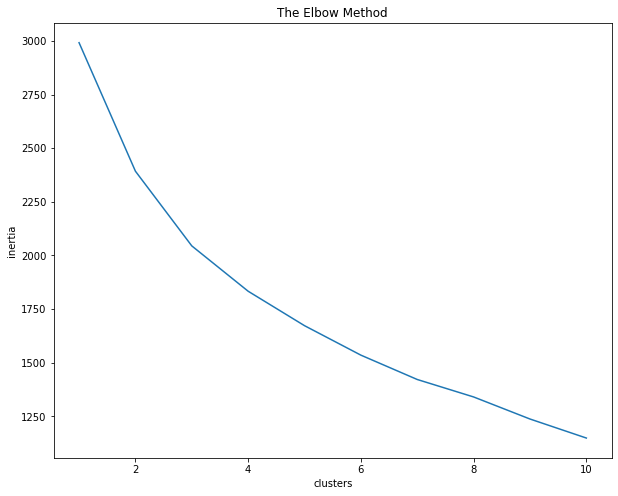

In [109]:
plt.figure(figsize=(10, 8))
interia = []
for i in range(1, 11):
    model = KMeans(n_clusters = i)
    model.fit(features)
    interia.append(model.inertia_)
plt.plot(range(1, 11), interia)
plt.title('The Elbow Method')
plt.xlabel('clusters')
plt.ylabel('inertia') #inertia is also known as within-cluster sum-of-squares and they are supposed to measure centroid distances,
#so in the graph when it starts to level off- it is usually seen as the optimal amount of clusters (this is known as the elbow method)
plt.show() #trying to find the most 

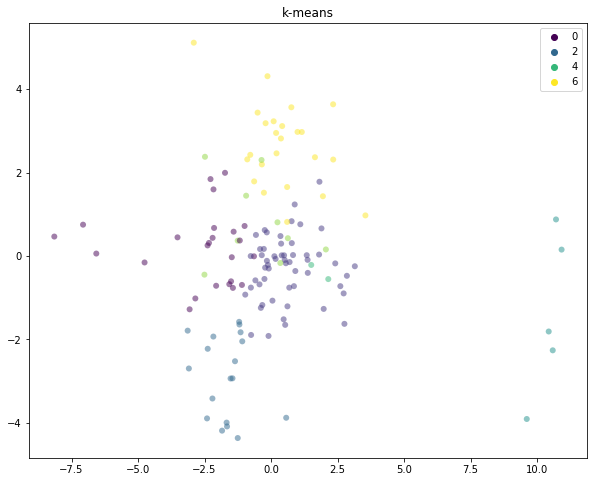

In [110]:
kmeans = KMeans(n_clusters=7) # using K-means 
y_kmeans = kmeans.fit_predict(features)
coordinates = TruncatedSVD().fit_transform(features)
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=coordinates[:, 0], 
    y=coordinates[:, 1],
    hue=y_kmeans,
    alpha=.5,
    palette='viridis',
    linewidth=0
    )
plt.title('k-means')
plt.show()

In [175]:
c_csv['fullname'] = ''
for i in range(len(c_csv)): 
    c_csv['author_surname'][i] = c_csv['author_surname'][i].lower()
    c_csv['author_givenname'][i] = c_csv['author_givenname'][i].lower()
    c_csv['fullname'][i] = c_csv['author_givenname'][i] + ' ' + c_csv['author_surname'][i]
fullname_list = list(c_csv['fullname'].unique())
for i in range(len(c_csv)): # using index of the list of unique values to make values numeric since classification can't use strings in models
    c_csv['fullname'][i] = fullname_list.index(c_csv['fullname'][i])
c_csv.head()

<ipython-input-175-2ed0c97ee691>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_csv['author_surname'][i] = c_csv['author_surname'][i].lower()
<ipython-input-175-2ed0c97ee691>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_csv['author_givenname'][i] = c_csv['author_givenname'][i].lower()
<ipython-input-175-2ed0c97ee691>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_csv['fullname'][i] = c_csv['author_givenname'][i] + ' ' + c

,owner,check_1,check_2,filename,title,author_surname,author_givenname,year,birth_year,genre,...,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,fullname
0,ks2373,aj445,jw2295,Little_Women_Alcott.txt,Little Women,alcott,louisa may,1868,1832,"comedy, children's literature",...,0.027066,0.008799,0.012736,0.028709,0.028802,0.051807,0.016159,0.013963,0.028673,0
1,jh976,sml347,jcm497,The_Great_God_Pan.txt,The Great God Pan,arthur,machen,1894,1863,Horror,...,0.019807,0.010686,0.018437,0.015540,0.030689,0.034055,0.017928,0.011195,0.023682,1
2,jz543,asc334,aml449,The_Lost_Kafoozalum.txt,The Lost Kafoozalum,ashwell,pauline,1960,1928,Science Fiction,...,0.019563,0.006082,0.015418,0.009220,0.025335,0.030100,0.012977,0.008639,0.019563,2
3,yw458,sml347,me363,mansfield_park.txt,Mansfield Park,austen,jane,1814,1775,"romance, historical",...,0.025265,0.006784,0.012423,0.022607,0.024807,0.050260,0.012880,0.011250,0.029703,3
4,kjk248,ay329,jcm497,pride_and_prejudice.txt,Pride and Prejudice,austen,jane,1813,1775,"fiction, romance",...,0.024625,0.006419,0.011948,0.022899,0.024843,0.051194,0.011927,0.011344,0.029052,3


In [183]:
X = c_csv.drop(['owner','check_1','check_2','gender','title','filename','author_surname','author_givenname','genre', 'source_url','downloads'], axis =1)
y = c_csv['gender']
y = y.astype(int)
X = scaler.fit_transform(X)
s = {} 
for i in classifiers: 
    s[i] = cross_validate( 
        classifiers[i], 
        X, 
        y,
        cv=10,
        scoring=['accuracy'] 
    )
compare_scores(s)

,fit_time,score_time,test_accuracy
kNN,0.000858,0.001607,0.691758
Decision tree,0.002324,0.000656,0.743956
Logit,0.008354,0.000434,0.638462
Random forest,0.116308,0.008303,0.751648


# 4. Results and discussion

Looking at the results, from classification, it seems that the Logistic Regression was the most accurate in determining the gender of the author. For determining whether a book will be adapted, the Random Forest Classifier was the most accurate. However, for both of these classifications they were only around 60% accurate, so I think it would be reasonable to say that these models were not very good at prediction. In regards to clustering, KMeans did not do a good job in accuratetly clustering the predicitions from where the actual points were. 

# 5. Reflection

I think a lot of the errors within the classification models come from considering white noise/unimportant features. Also, looking at the data, it is possible that the features that were in the csv are simply not good as variables for predicting/determining gender of the author or whether it will be adapated or not. I think for determining gender, sentiment analysis would be a good additional feature to look at (or gendered sentiment analysis), and for determining adaptation sales or popularity would be a good feature to analyze. 

# 6. Responsibility and resources consulted